In [1]:
# Install PyTorch Forecasting (includes Temporal Fusion Transformer)
# 安装 PyTorch Forecasting（包含 TFT 模型）
# !pip install pytorch-forecasting lightning


In [2]:
from pytorch_forecasting.metrics import MAE, SMAPE, QuantileLoss
from pytorch_forecasting.data import GroupNormalizer
from sklearn.model_selection import TimeSeriesSplit
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
import lightning.pytorch as pl
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pathlib import Path

import os
import shutil

# Import PyTorch Forecasting TFT and related modules
# 导入 PyTorch Forecasting TFT 及相关模块
import warnings
warnings.filterwarnings("ignore")


print("PyTorch Forecasting TFT imported successfully!")
print(f"PyTorch version: {torch.__version__}")


/Users/ty/Downloads/STAT6207/STAT6207_project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch Forecasting TFT imported successfully!
PyTorch version: 2.9.1


In [3]:
# ============================================================
# Device Selection (GPU/MPS/CPU)
# ============================================================

# Check for CUDA availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA is available!")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Fall back to CPU
else:
    device = torch.device("cpu")
    print(f"Using CPU device")

print(f"\nSelected device: {device}")
torch.set_default_device(device)
torch.set_default_dtype(torch.float32)

Using CPU device

Selected device: cpu


In [4]:
# Setup custom logger
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('training.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

In [5]:
# Load training data with historical sales and features
# 加载包含历史销售和特征的训练数据

proj_root = Path("/Users/ty/Downloads/STAT6207/STAT6207_project")
data_folder = Path(proj_root / "data")

df_raw = (
    pd.read_csv(
        data_folder / 'target_series_new_with_features2.csv',
        dtype={
            "isbn": "string",
            "q_num": "string"
        }
    )
)

# ============================================================
# CRITICAL FIX: Aggregate data by ISBN + Quarter
# The raw data has multiple rows per ISBN per quarter (different channels)
# We need to SUM the quantities across channels for each ISBN-quarter
# 关键修复：按ISBN+季度汇总数据
# ============================================================

print("📊 Raw data shape:", df_raw.shape)
print(f"   Unique ISBNs: {df_raw['isbn'].nunique()}")
print(f"   Sample quantity values: {df_raw['quantity'].head(10).tolist()}")

# Aggregate quantity by ISBN + quarter (sum across all channels)
# Keep the first value for static features (they're the same per ISBN)
agg_dict = {
    'quantity': 'sum',  # SUM quantity across channels
    'series': 'first',
    'format': 'first',
    'channel': 'first',  # Keep one channel as reference
    'year_quarter': 'first',
    'q_since_first': 'first',
    'avg_discount_rate': 'mean',  # Average discount rate
    'print_length': 'first',
    'item_weight': 'first',
    'length': 'first',
    'width': 'first',
    'height': 'first',
    'rating': 'first',
    'price': 'first'
}

# Check if 'title' column exists before dropping
if 'title' in df_raw.columns:
    df_raw_no_title = df_raw.drop(columns=["title"])
else:
    df_raw_no_title = df_raw

# Aggregate by ISBN and q_num (quarter)
df = df_raw_no_title.groupby(['isbn', 'q_num']).agg(agg_dict).reset_index()

print(f"\n✅ After aggregation:")
print(f"   Shape: {df.shape}")
print(f"   Unique ISBNs: {df['isbn'].nunique()}")
print(f"   Quantity stats after SUM aggregation:")
print(f"     Mean: {df['quantity'].mean():.1f}")
print(f"     Median: {df['quantity'].median():.1f}")
print(f"     Max: {df['quantity'].max():.1f}")
print(f"     Min: {df['quantity'].min():.1f}")

# Show sample of aggregated data
print("\n📋 Sample aggregated data (first 5 rows):")
print(df[['isbn', 'q_num', 'series', 'quantity']].head(10))

# Load target books for 2026 prediction
# 加载2026年需要预测的目标书籍
target_books = (
    pd.read_csv(
        data_folder / 'target_books_new.csv',
        dtype={
            "isbn": "string",
            "q_num": "string"
        }
    )
)
if 'title' in target_books.columns:
    # Keep titles for later
    target_books_titles = target_books[['isbn', 'title']].drop_duplicates()
    target_books = target_books.drop(columns=["title"])

print(f"\n📚 Target books loaded: {len(target_books)} rows")


📊 Raw data shape: (3083, 17)
   Unique ISBNs: 119
   Sample quantity values: [174.0, 122.0, 114.0, 104.0, 53.0, 50.0, 37.0, 33.0, 32.0, 32.0]

✅ After aggregation:
   Shape: (423, 16)
   Unique ISBNs: 119
   Quantity stats after SUM aggregation:
     Mean: 149.2
     Median: 46.0
     Max: 1873.0
     Min: 1.0

📋 Sample aggregated data (first 5 rows):
            isbn q_num              series  quantity
0  9780545175340     1  captain_underpants      17.0
1  9780545175340     2  captain_underpants      16.0
2  9780545175340     3  captain_underpants      30.0
3  9780545175340     4  captain_underpants      29.0
4  9780545175364     1  captain_underpants      13.0
5  9780545175364     2  captain_underpants       5.0
6  9780545175364     3  captain_underpants      14.0
7  9780545175364     4  captain_underpants      18.0
8  9780545375627     1  captain_underpants       1.0
9  9780545385794     3  captain_underpants      27.0

📚 Target books loaded: 32 rows


In [6]:
# Define all training hyperparameters here
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
DECAY = 0
DROP = 0
PATIENCE = 30
HIDDEN_SIZE = 64
ATTENTION_HEAD_SIZE = 4
HIDDEN_CONTINUOUS_SIZE = 32
LOG_INTERVAL = 10

# Define max encoder/prediction lengths
MAX_ENCODER_LENGTH = 8   # Use last 8 quarters as history
MAX_PREDICTION_LENGTH = 4  # Predict next 4 quarters (1 year)
MAX_PREDICTION_LENGTH_FOR_SPLIT = 4


In [7]:
# Ensure categorical columns are string type (required by TFT)
# 确保分类列是字符串类型（TFT 要求）
df['q_num'] = df['q_num'].astype(str)
df['series'] = df['series'].astype(str)
df['format'] = df['format'].astype(str)
df['channel'] = df['channel'].astype(str)

# ============================================================
# Impute Missing Values with MEDIAN (no data leakage)
# 使用中位数填补缺失值（无数据泄漏）
# ============================================================

# Define training cutoff FIRST to avoid data leakage
# Use q_since_first (integer) as the time index - consistent with TFT setup
# 使用 q_since_first（整数）作为时间索引 - 与 TFT 设置一致
training_cutoff_for_impute = df["q_since_first"].max(
) - MAX_PREDICTION_LENGTH_FOR_SPLIT

# Split into train/validation by TIME using q_since_first (not random!)
# 使用 q_since_first 按时间分割训练/验证集
train_mask = df["q_since_first"] <= training_cutoff_for_impute
train_df_temp = df[train_mask]

# List of numeric columns to impute
# 需要填补的数值列
cols_to_impute = [
    "print_length", "item_weight", "length", "width", "height",
    "rating", "price", "avg_discount_rate"
]

# Check missing values before imputation
print("Missing values BEFORE imputation:")
for col in cols_to_impute:
    if col in df.columns:
        missing = df[col].isna().sum()
        pct = missing / len(df) * 100
        print(f"  {col}: {missing} ({pct:.1f}%)")

# Create df_imputed - keep original df unchanged
# 创建 df_imputed - 保持原始 df 不变
df_imputed = df.copy()

# Calculate MEDIAN from TRAINING data only (no leakage)
# 仅从训练数据计算中位数（无数据泄漏）
print("\nImputing with TRAINING data medians:")
for col in cols_to_impute:
    if col in df_imputed.columns:
        # Calculate median from training data only
        train_median = train_df_temp[col].median()

        # If training median is NaN, use overall median as fallback
        if pd.isna(train_median):
            train_median = df[col].median()
            print(
                f"  {col}: using overall median = {train_median:.4f} (no training data)")
        else:
            print(f"  {col}: training median = {train_median:.4f}")

        # Fill missing values in df_imputed
        df_imputed[col] = df_imputed[col].fillna(train_median)

        missing = df_imputed[col].isna().sum()
        print(f"  {col}: {missing}")

print(f"\nTraining cutoff (q_since_first): {training_cutoff_for_impute}")
print(
    f"Training samples: {train_mask.sum()}, Validation samples: {(~train_mask).sum()}")
print("\n✅ Missing values imputed using TRAINING data medians (no data leakage)")
print("📌 Original df preserved, use df_imputed for TFT")


Missing values BEFORE imputation:
  print_length: 274 (64.8%)
  item_weight: 274 (64.8%)
  length: 274 (64.8%)
  width: 274 (64.8%)
  height: 274 (64.8%)
  rating: 274 (64.8%)
  price: 274 (64.8%)
  avg_discount_rate: 0 (0.0%)

Imputing with TRAINING data medians:
  print_length: training median = 240.0000
  print_length: 0
  item_weight: training median = 34.4800
  item_weight: 0
  length: training median = 8.5000
  length: 0
  width: training median = 5.7500
  width: 0
  height: training median = 0.7500
  height: 0
  rating: training median = 4.8000
  rating: 0
  price: training median = 7.9900
  price: 0
  avg_discount_rate: training median = 10.8405
  avg_discount_rate: 0

Training cutoff (q_since_first): 24
Training samples: 418, Validation samples: 5

✅ Missing values imputed using TRAINING data medians (no data leakage)
📌 Original df preserved, use df_imputed for TFT


In [8]:
# # ============================================================
# # Convert numeric columns to float32 for device compatibility
# # ============================================================

# print("Converting numeric columns to float32...")

# numeric_cols = df_imputed.select_dtypes(include=['float64', 'float32']).columns
# for col in numeric_cols:
#     if df_imputed[col].dtype == 'float64':
#         print(f"  {col}: float64 -> float32")
#         df_imputed[col] = df_imputed[col].astype('float32')

# # Ensure integer columns are correct type
# df_imputed['q_since_first'] = df_imputed['q_since_first'].astype('int64')

# print("Data type conversion complete!")
# print("\nDataFrame dtypes after conversion:")
# print(df_imputed.dtypes)

In [9]:
# ============================================================
# Temporal Fusion Transformer (TFT) Setup
# 时态融合变压器 (TFT) 设置
# ============================================================

# Data Preprocessing for TFT
# TFT 数据预处理

# TFT requires time_idx to be INTEGER, not datetime!
# Use q_since_first as the time index (0, 1, 2, 3... quarters since first sell)
# TFT 要求 time_idx 是整数，不是日期时间！
# 使用 q_since_first 作为时间索引（自首次销售以来的季度数：0, 1, 2, 3...）

# Check the range of q_since_first in the data
print(
    f"q_since_first range: {df_imputed['q_since_first'].min()} to {df_imputed['q_since_first'].max()}")
print(f"Number of unique ISBNs: {df_imputed['isbn'].nunique()}")

# Get training cutoff (using integer time index)
training_cutoff = df_imputed["q_since_first"].max() - MAX_PREDICTION_LENGTH
print(f"Training cutoff: {training_cutoff}")

# Filter training data
train_data = df_imputed[df_imputed["q_since_first"] <= training_cutoff].copy()
print(f"Training data rows: {len(train_data)}")

# ============================================================
# FIX: Ensure all time series have encoder_length <= MAX_ENCODER_LENGTH
# The error occurs because some series have more history than MAX_ENCODER_LENGTH
# We need to truncate each series to only keep the most recent MAX_ENCODER_LENGTH + MAX_PREDICTION_LENGTH quarters
# ============================================================


def truncate_time_series(data, max_history):
    """Keep only the most recent max_history quarters per ISBN for training"""
    truncated = []
    for isbn, group in data.groupby("isbn"):
        # Sort by time index
        group = group.sort_values("q_since_first")
        # Keep only the most recent entries that fit within our window
        if len(group) > max_history:
            group = group.tail(max_history)
        truncated.append(group)
    return pd.concat(truncated, ignore_index=True)


# Maximum history we want to keep per book: encoder + prediction length
max_history_per_book = MAX_ENCODER_LENGTH + MAX_PREDICTION_LENGTH

# Truncate training data to avoid encoder lengths > MAX_ENCODER_LENGTH
train_data_truncated = truncate_time_series(train_data, max_history_per_book)
print(f"Training data rows after truncation: {len(train_data_truncated)}")

# Create TimeSeriesDataSet for training
# 创建训练用的 TimeSeriesDataSet
training = TimeSeriesDataSet(
    train_data_truncated,
    time_idx="q_since_first",  # Must be integer!
    target="quantity",
    group_ids=["isbn"],  # Each book is a separate time series
    min_encoder_length=1,  # Allow shorter sequences
    max_encoder_length=MAX_ENCODER_LENGTH,
    min_prediction_length=1,
    max_prediction_length=MAX_PREDICTION_LENGTH,

    # Allow missing timesteps (some books may have gaps in quarterly data)
    allow_missing_timesteps=True,

    # Static features (don't change over time for a book)
    static_categoricals=["series", "format", "channel"],
    static_reals=["print_length", "width", "height", "item_weight"],

    # Time-varying known features (known in advance)
    time_varying_known_categoricals=["q_num"],
    time_varying_known_reals=[],

    # Time-varying unknown features (only known up to current time)
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["avg_discount_rate"],

    # Target normalization
    target_normalizer=GroupNormalizer(
        groups=["isbn"],
        transformation="softplus"
    ),

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# Truncate validation data too
val_data_truncated = truncate_time_series(df_imputed, max_history_per_book)
print(f"Validation data rows after truncation: {len(val_data_truncated)}")

# Create validation dataset from truncated data
validation = TimeSeriesDataSet.from_dataset(
    training,
    val_data_truncated,  # Use truncated data!
    predict=True,
    stop_randomization=True,
)

# Create dataloaders
train_dataloader = training.to_dataloader(
    train=True,
    batch_size=BATCH_SIZE,
    num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False,
    batch_size=BATCH_SIZE,
    num_workers=0
)

print(f"\nTraining samples: {len(training)}")
print(f"Validation samples: {len(validation)}")

# ============================================================
# Initialize Temporal Fusion Transformer Model
# 初始化时态融合变压器模型
# ============================================================

# Configure TFT model
# log_interval=-1 disables interpretation logging during training
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=LEARNING_RATE,
    hidden_size=HIDDEN_SIZE,
    attention_head_size=ATTENTION_HEAD_SIZE,
    dropout=DROP,
    hidden_continuous_size=HIDDEN_CONTINUOUS_SIZE,
    loss=QuantileLoss(),
    # Disable to avoid histogram error during training
    log_interval=MAX_ENCODER_LENGTH // 2 == 4,
    optimizer="Adam",
    reduce_on_plateau_patience=PATIENCE // 3,
)

print(f"\nTFT Model initialized!")
print(f"Number of parameters: {tft.size()/1e3:.1f}k")
print(f"\nModel Configuration:")
print(f"  - Hidden size: {HIDDEN_SIZE}")
print(f"  - Attention heads: {ATTENTION_HEAD_SIZE}")
print(f"  - Dropout: {DROP}")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Max encoder length: {MAX_ENCODER_LENGTH}")
print(f"  - Max prediction length: {MAX_PREDICTION_LENGTH}")


q_since_first range: 0 to 28
Number of unique ISBNs: 119
Training cutoff: 24
Training data rows: 418
Training data rows after truncation: 418
Validation data rows after truncation: 423

Training samples: 481
Validation samples: 41

TFT Model initialized!
Number of parameters: 279.0k

Model Configuration:
  - Hidden size: 64
  - Attention heads: 4
  - Dropout: 0
  - Learning rate: 0.0001
  - Batch size: 128
  - Max encoder length: 8
  - Max prediction length: 4


In [10]:
# ============================================================
# Step 7: Train TFT Model
# 训练 TFT 模型
# ============================================================
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt
import os

# Create log directory with absolute path
log_dir = os.path.abspath("lightning_logs_tft")
os.makedirs(log_dir, exist_ok=True)

# Configure trainer with callbacks
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=PATIENCE,
    verbose=True,
    mode="min"
)

lr_logger = LearningRateMonitor()

# Use CSVLogger instead of TensorBoard to avoid the directory issue
logger = CSVLogger(save_dir=log_dir, name="tft_feature_selection")

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

# Train the model
print("🚀 Starting TFT Training...")
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

print("✅ TFT Training Complete!")


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


🚀 Starting TFT Training...



   | Name                               | Type                            | Params | Mode  | FLOPs
--------------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train | 0    
1  | logging_metrics                    | ModuleList                      | 0      | train | 0    
2  | input_embeddings                   | MultiEmbedding                  | 54     | train | 0    
3  | prescalers                         | ModuleDict                      | 576    | train | 0    
4  | static_variable_selection          | VariableSelectionNetwork        | 50.3 K | train | 0    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 14.1 K | train | 0    
6  | decoder_variable_selection         | VariableSelectionNetwork        | 7.1 K  | train | 0    
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K | train | 0    
8  

Epoch 0: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s, v_num=4, train_loss_step=118.0, val_loss=65.30, train_loss_epoch=108.0]

Metric val_loss improved. New best score: 65.347


Epoch 1: 100%|██████████| 3/3 [00:00<00:00,  4.13it/s, v_num=4, train_loss_step=80.00, val_loss=61.30, train_loss_epoch=90.40]

Metric val_loss improved by 4.078 >= min_delta = 0.0001. New best score: 61.269


Epoch 2: 100%|██████████| 3/3 [00:00<00:00,  4.38it/s, v_num=4, train_loss_step=81.00, val_loss=57.40, train_loss_epoch=92.10]

Metric val_loss improved by 3.917 >= min_delta = 0.0001. New best score: 57.352


Epoch 3: 100%|██████████| 3/3 [00:00<00:00,  4.18it/s, v_num=4, train_loss_step=80.90, val_loss=53.30, train_loss_epoch=83.70]

Metric val_loss improved by 4.051 >= min_delta = 0.0001. New best score: 53.301


Epoch 4: 100%|██████████| 3/3 [00:00<00:00,  4.12it/s, v_num=4, train_loss_step=69.50, val_loss=49.40, train_loss_epoch=83.50]

Metric val_loss improved by 3.946 >= min_delta = 0.0001. New best score: 49.356


Epoch 5: 100%|██████████| 3/3 [00:00<00:00,  4.07it/s, v_num=4, train_loss_step=73.70, val_loss=45.60, train_loss_epoch=70.90]

Metric val_loss improved by 3.788 >= min_delta = 0.0001. New best score: 45.567


Epoch 6: 100%|██████████| 3/3 [00:00<00:00,  4.32it/s, v_num=4, train_loss_step=74.00, val_loss=41.90, train_loss_epoch=64.50]

Metric val_loss improved by 3.621 >= min_delta = 0.0001. New best score: 41.946


Epoch 7: 100%|██████████| 3/3 [00:00<00:00,  4.69it/s, v_num=4, train_loss_step=60.40, val_loss=38.60, train_loss_epoch=61.20]

Metric val_loss improved by 3.331 >= min_delta = 0.0001. New best score: 38.615


Epoch 8: 100%|██████████| 3/3 [00:00<00:00,  4.44it/s, v_num=4, train_loss_step=50.50, val_loss=35.60, train_loss_epoch=53.20]

Metric val_loss improved by 3.052 >= min_delta = 0.0001. New best score: 35.563


Epoch 9: 100%|██████████| 3/3 [00:00<00:00,  4.53it/s, v_num=4, train_loss_step=55.10, val_loss=32.70, train_loss_epoch=52.70]

Metric val_loss improved by 2.853 >= min_delta = 0.0001. New best score: 32.710


Epoch 10: 100%|██████████| 3/3 [00:00<00:00,  4.50it/s, v_num=4, train_loss_step=34.10, val_loss=30.10, train_loss_epoch=45.70]

Metric val_loss improved by 2.631 >= min_delta = 0.0001. New best score: 30.079


Epoch 11: 100%|██████████| 3/3 [00:00<00:00,  4.57it/s, v_num=4, train_loss_step=35.70, val_loss=27.70, train_loss_epoch=40.10]

Metric val_loss improved by 2.350 >= min_delta = 0.0001. New best score: 27.728


Epoch 12: 100%|██████████| 3/3 [00:00<00:00,  4.35it/s, v_num=4, train_loss_step=43.70, val_loss=25.70, train_loss_epoch=39.90]

Metric val_loss improved by 1.998 >= min_delta = 0.0001. New best score: 25.730


Epoch 13: 100%|██████████| 3/3 [00:00<00:00,  4.45it/s, v_num=4, train_loss_step=31.60, val_loss=24.10, train_loss_epoch=33.10]

Metric val_loss improved by 1.611 >= min_delta = 0.0001. New best score: 24.119


Epoch 14: 100%|██████████| 3/3 [00:00<00:00,  4.37it/s, v_num=4, train_loss_step=32.60, val_loss=22.90, train_loss_epoch=32.90]

Metric val_loss improved by 1.240 >= min_delta = 0.0001. New best score: 22.879


Epoch 15: 100%|██████████| 3/3 [00:00<00:00,  3.58it/s, v_num=4, train_loss_step=31.60, val_loss=21.90, train_loss_epoch=31.40]

Metric val_loss improved by 1.019 >= min_delta = 0.0001. New best score: 21.860


Epoch 16: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s, v_num=4, train_loss_step=28.00, val_loss=21.20, train_loss_epoch=27.20]

Metric val_loss improved by 0.706 >= min_delta = 0.0001. New best score: 21.154


Epoch 17: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s, v_num=4, train_loss_step=35.90, val_loss=20.60, train_loss_epoch=27.30]

Metric val_loss improved by 0.548 >= min_delta = 0.0001. New best score: 20.606


Epoch 18: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s, v_num=4, train_loss_step=31.80, val_loss=19.90, train_loss_epoch=27.40]

Metric val_loss improved by 0.699 >= min_delta = 0.0001. New best score: 19.907


Epoch 19: 100%|██████████| 3/3 [00:00<00:00,  4.17it/s, v_num=4, train_loss_step=30.70, val_loss=19.20, train_loss_epoch=26.50]

Metric val_loss improved by 0.704 >= min_delta = 0.0001. New best score: 19.203


Epoch 20: 100%|██████████| 3/3 [00:00<00:00,  4.10it/s, v_num=4, train_loss_step=28.40, val_loss=18.60, train_loss_epoch=25.50]

Metric val_loss improved by 0.587 >= min_delta = 0.0001. New best score: 18.616


Epoch 21: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s, v_num=4, train_loss_step=24.10, val_loss=18.30, train_loss_epoch=24.70]

Metric val_loss improved by 0.357 >= min_delta = 0.0001. New best score: 18.259


Epoch 22: 100%|██████████| 3/3 [00:00<00:00,  4.26it/s, v_num=4, train_loss_step=24.80, val_loss=17.90, train_loss_epoch=26.30]

Metric val_loss improved by 0.311 >= min_delta = 0.0001. New best score: 17.948


Epoch 23: 100%|██████████| 3/3 [00:00<00:00,  4.38it/s, v_num=4, train_loss_step=21.30, val_loss=17.60, train_loss_epoch=24.00]

Metric val_loss improved by 0.361 >= min_delta = 0.0001. New best score: 17.587


Epoch 24: 100%|██████████| 3/3 [00:00<00:00,  3.78it/s, v_num=4, train_loss_step=25.00, val_loss=17.40, train_loss_epoch=26.20]

Metric val_loss improved by 0.219 >= min_delta = 0.0001. New best score: 17.368


Epoch 25: 100%|██████████| 3/3 [00:00<00:00,  4.43it/s, v_num=4, train_loss_step=25.60, val_loss=17.20, train_loss_epoch=25.70]

Metric val_loss improved by 0.210 >= min_delta = 0.0001. New best score: 17.157


Epoch 26: 100%|██████████| 3/3 [00:00<00:00,  4.25it/s, v_num=4, train_loss_step=23.00, val_loss=16.90, train_loss_epoch=23.30]

Metric val_loss improved by 0.284 >= min_delta = 0.0001. New best score: 16.874


Epoch 27: 100%|██████████| 3/3 [00:00<00:00,  4.28it/s, v_num=4, train_loss_step=26.80, val_loss=16.60, train_loss_epoch=24.20]

Metric val_loss improved by 0.260 >= min_delta = 0.0001. New best score: 16.614


Epoch 28: 100%|██████████| 3/3 [00:00<00:00,  4.33it/s, v_num=4, train_loss_step=20.50, val_loss=16.50, train_loss_epoch=24.20]

Metric val_loss improved by 0.147 >= min_delta = 0.0001. New best score: 16.467


Epoch 29: 100%|██████████| 3/3 [00:00<00:00,  4.30it/s, v_num=4, train_loss_step=19.30, val_loss=16.30, train_loss_epoch=23.80]

Metric val_loss improved by 0.191 >= min_delta = 0.0001. New best score: 16.276


Epoch 30: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s, v_num=4, train_loss_step=27.20, val_loss=16.00, train_loss_epoch=24.40]

Metric val_loss improved by 0.302 >= min_delta = 0.0001. New best score: 15.974


Epoch 31: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s, v_num=4, train_loss_step=22.00, val_loss=15.70, train_loss_epoch=24.60]

Metric val_loss improved by 0.256 >= min_delta = 0.0001. New best score: 15.718


Epoch 32: 100%|██████████| 3/3 [00:00<00:00,  4.33it/s, v_num=4, train_loss_step=19.10, val_loss=15.50, train_loss_epoch=22.60]

Metric val_loss improved by 0.227 >= min_delta = 0.0001. New best score: 15.490


Epoch 33: 100%|██████████| 3/3 [00:00<00:00,  4.21it/s, v_num=4, train_loss_step=20.90, val_loss=15.30, train_loss_epoch=23.70]

Metric val_loss improved by 0.204 >= min_delta = 0.0001. New best score: 15.286


Epoch 34: 100%|██████████| 3/3 [00:00<00:00,  4.49it/s, v_num=4, train_loss_step=22.80, val_loss=15.10, train_loss_epoch=23.50]

Metric val_loss improved by 0.164 >= min_delta = 0.0001. New best score: 15.123


Epoch 35: 100%|██████████| 3/3 [00:00<00:00,  4.43it/s, v_num=4, train_loss_step=18.80, val_loss=15.00, train_loss_epoch=23.40]

Metric val_loss improved by 0.092 >= min_delta = 0.0001. New best score: 15.031


Epoch 36: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s, v_num=4, train_loss_step=23.00, val_loss=14.90, train_loss_epoch=24.00]

Metric val_loss improved by 0.109 >= min_delta = 0.0001. New best score: 14.922


Epoch 37: 100%|██████████| 3/3 [00:00<00:00,  3.74it/s, v_num=4, train_loss_step=26.30, val_loss=14.80, train_loss_epoch=23.40]

Metric val_loss improved by 0.157 >= min_delta = 0.0001. New best score: 14.765


Epoch 38: 100%|██████████| 3/3 [00:00<00:00,  4.17it/s, v_num=4, train_loss_step=22.20, val_loss=14.60, train_loss_epoch=23.10]

Metric val_loss improved by 0.161 >= min_delta = 0.0001. New best score: 14.604


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  4.33it/s, v_num=4, train_loss_step=21.00, val_loss=14.50, train_loss_epoch=23.90]

Metric val_loss improved by 0.135 >= min_delta = 0.0001. New best score: 14.469


Epoch 40: 100%|██████████| 3/3 [00:00<00:00,  4.19it/s, v_num=4, train_loss_step=22.80, val_loss=14.30, train_loss_epoch=22.80]

Metric val_loss improved by 0.136 >= min_delta = 0.0001. New best score: 14.333


Epoch 41: 100%|██████████| 3/3 [00:00<00:00,  4.25it/s, v_num=4, train_loss_step=22.70, val_loss=14.20, train_loss_epoch=23.80]

Metric val_loss improved by 0.117 >= min_delta = 0.0001. New best score: 14.216


Epoch 42: 100%|██████████| 3/3 [00:00<00:00,  4.40it/s, v_num=4, train_loss_step=25.90, val_loss=14.10, train_loss_epoch=22.00]

Metric val_loss improved by 0.155 >= min_delta = 0.0001. New best score: 14.061


Epoch 43: 100%|██████████| 3/3 [00:00<00:00,  4.43it/s, v_num=4, train_loss_step=25.30, val_loss=14.00, train_loss_epoch=23.10]

Metric val_loss improved by 0.084 >= min_delta = 0.0001. New best score: 13.977


Epoch 44: 100%|██████████| 3/3 [00:00<00:00,  4.35it/s, v_num=4, train_loss_step=18.60, val_loss=13.90, train_loss_epoch=21.30]

Metric val_loss improved by 0.098 >= min_delta = 0.0001. New best score: 13.880


Epoch 45: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s, v_num=4, train_loss_step=26.90, val_loss=13.80, train_loss_epoch=23.00]

Metric val_loss improved by 0.049 >= min_delta = 0.0001. New best score: 13.831


Epoch 46: 100%|██████████| 3/3 [00:00<00:00,  4.18it/s, v_num=4, train_loss_step=19.50, val_loss=13.80, train_loss_epoch=22.60]

Metric val_loss improved by 0.043 >= min_delta = 0.0001. New best score: 13.789


Epoch 47: 100%|██████████| 3/3 [00:00<00:00,  4.42it/s, v_num=4, train_loss_step=20.20, val_loss=13.70, train_loss_epoch=21.60]

Metric val_loss improved by 0.091 >= min_delta = 0.0001. New best score: 13.697


Epoch 48: 100%|██████████| 3/3 [00:00<00:00,  4.40it/s, v_num=4, train_loss_step=16.00, val_loss=13.60, train_loss_epoch=21.60]

Metric val_loss improved by 0.136 >= min_delta = 0.0001. New best score: 13.562


Epoch 49: 100%|██████████| 3/3 [00:00<00:00,  4.34it/s, v_num=4, train_loss_step=20.70, val_loss=13.40, train_loss_epoch=21.10]

Metric val_loss improved by 0.143 >= min_delta = 0.0001. New best score: 13.419


Epoch 50: 100%|██████████| 3/3 [00:00<00:00,  4.07it/s, v_num=4, train_loss_step=21.10, val_loss=13.30, train_loss_epoch=22.90]

Metric val_loss improved by 0.076 >= min_delta = 0.0001. New best score: 13.344


Epoch 51: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s, v_num=4, train_loss_step=19.70, val_loss=13.20, train_loss_epoch=20.20]

Metric val_loss improved by 0.113 >= min_delta = 0.0001. New best score: 13.230


Epoch 52: 100%|██████████| 3/3 [00:00<00:00,  4.23it/s, v_num=4, train_loss_step=19.40, val_loss=13.20, train_loss_epoch=21.30]

Metric val_loss improved by 0.075 >= min_delta = 0.0001. New best score: 13.155


Epoch 53: 100%|██████████| 3/3 [00:00<00:00,  4.14it/s, v_num=4, train_loss_step=19.40, val_loss=13.00, train_loss_epoch=21.30]

Metric val_loss improved by 0.133 >= min_delta = 0.0001. New best score: 13.023


Epoch 54: 100%|██████████| 3/3 [00:00<00:00,  4.16it/s, v_num=4, train_loss_step=20.90, val_loss=12.90, train_loss_epoch=22.00]

Metric val_loss improved by 0.118 >= min_delta = 0.0001. New best score: 12.905


Epoch 55: 100%|██████████| 3/3 [00:00<00:00,  4.46it/s, v_num=4, train_loss_step=20.00, val_loss=12.90, train_loss_epoch=20.50]

Metric val_loss improved by 0.042 >= min_delta = 0.0001. New best score: 12.863


Epoch 56: 100%|██████████| 3/3 [00:00<00:00,  4.33it/s, v_num=4, train_loss_step=21.30, val_loss=12.80, train_loss_epoch=20.30]

Metric val_loss improved by 0.071 >= min_delta = 0.0001. New best score: 12.792


Epoch 57: 100%|██████████| 3/3 [00:00<00:00,  4.33it/s, v_num=4, train_loss_step=18.70, val_loss=12.70, train_loss_epoch=21.90]

Metric val_loss improved by 0.134 >= min_delta = 0.0001. New best score: 12.658


Epoch 58: 100%|██████████| 3/3 [00:00<00:00,  4.30it/s, v_num=4, train_loss_step=16.60, val_loss=12.60, train_loss_epoch=20.20]

Metric val_loss improved by 0.098 >= min_delta = 0.0001. New best score: 12.560


Epoch 59: 100%|██████████| 3/3 [00:00<00:00,  4.40it/s, v_num=4, train_loss_step=21.30, val_loss=12.40, train_loss_epoch=20.10]

Metric val_loss improved by 0.115 >= min_delta = 0.0001. New best score: 12.445


Epoch 60: 100%|██████████| 3/3 [00:00<00:00,  4.29it/s, v_num=4, train_loss_step=17.90, val_loss=12.30, train_loss_epoch=18.80]

Metric val_loss improved by 0.140 >= min_delta = 0.0001. New best score: 12.305


Epoch 61: 100%|██████████| 3/3 [00:00<00:00,  4.27it/s, v_num=4, train_loss_step=20.00, val_loss=12.20, train_loss_epoch=19.60]

Metric val_loss improved by 0.150 >= min_delta = 0.0001. New best score: 12.155


Epoch 62: 100%|██████████| 3/3 [00:00<00:00,  4.24it/s, v_num=4, train_loss_step=18.90, val_loss=12.10, train_loss_epoch=21.00]

Metric val_loss improved by 0.095 >= min_delta = 0.0001. New best score: 12.060


Epoch 63: 100%|██████████| 3/3 [00:00<00:00,  4.28it/s, v_num=4, train_loss_step=18.20, val_loss=12.00, train_loss_epoch=19.20]

Metric val_loss improved by 0.078 >= min_delta = 0.0001. New best score: 11.982


Epoch 64: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s, v_num=4, train_loss_step=18.50, val_loss=11.90, train_loss_epoch=19.70]

Metric val_loss improved by 0.070 >= min_delta = 0.0001. New best score: 11.912


Epoch 65: 100%|██████████| 3/3 [00:00<00:00,  4.40it/s, v_num=4, train_loss_step=18.10, val_loss=11.80, train_loss_epoch=19.80]

Metric val_loss improved by 0.137 >= min_delta = 0.0001. New best score: 11.774


Epoch 66: 100%|██████████| 3/3 [00:00<00:00,  4.22it/s, v_num=4, train_loss_step=22.60, val_loss=11.70, train_loss_epoch=19.60]

Metric val_loss improved by 0.103 >= min_delta = 0.0001. New best score: 11.671


Epoch 67: 100%|██████████| 3/3 [00:00<00:00,  4.07it/s, v_num=4, train_loss_step=17.20, val_loss=11.60, train_loss_epoch=19.60]

Metric val_loss improved by 0.067 >= min_delta = 0.0001. New best score: 11.604


Epoch 68: 100%|██████████| 3/3 [00:00<00:00,  4.34it/s, v_num=4, train_loss_step=17.70, val_loss=11.40, train_loss_epoch=19.20]

Metric val_loss improved by 0.160 >= min_delta = 0.0001. New best score: 11.444


Epoch 69: 100%|██████████| 3/3 [00:00<00:00,  4.25it/s, v_num=4, train_loss_step=18.10, val_loss=11.30, train_loss_epoch=19.20]

Metric val_loss improved by 0.110 >= min_delta = 0.0001. New best score: 11.334


Epoch 70: 100%|██████████| 3/3 [00:00<00:00,  4.28it/s, v_num=4, train_loss_step=19.00, val_loss=11.30, train_loss_epoch=19.70]

Metric val_loss improved by 0.079 >= min_delta = 0.0001. New best score: 11.255


Epoch 71: 100%|██████████| 3/3 [00:00<00:00,  4.46it/s, v_num=4, train_loss_step=18.40, val_loss=11.10, train_loss_epoch=19.90]

Metric val_loss improved by 0.111 >= min_delta = 0.0001. New best score: 11.144


Epoch 72: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s, v_num=4, train_loss_step=19.20, val_loss=11.10, train_loss_epoch=19.70]

Metric val_loss improved by 0.056 >= min_delta = 0.0001. New best score: 11.088


Epoch 73: 100%|██████████| 3/3 [00:00<00:00,  4.35it/s, v_num=4, train_loss_step=16.00, val_loss=11.00, train_loss_epoch=19.20]

Metric val_loss improved by 0.122 >= min_delta = 0.0001. New best score: 10.966


Epoch 74: 100%|██████████| 3/3 [00:00<00:00,  4.21it/s, v_num=4, train_loss_step=22.90, val_loss=10.90, train_loss_epoch=18.40]

Metric val_loss improved by 0.097 >= min_delta = 0.0001. New best score: 10.870


Epoch 75: 100%|██████████| 3/3 [00:00<00:00,  4.14it/s, v_num=4, train_loss_step=17.80, val_loss=10.80, train_loss_epoch=18.60]

Metric val_loss improved by 0.051 >= min_delta = 0.0001. New best score: 10.818


Epoch 76: 100%|██████████| 3/3 [00:00<00:00,  4.06it/s, v_num=4, train_loss_step=16.70, val_loss=10.80, train_loss_epoch=17.90]

Metric val_loss improved by 0.023 >= min_delta = 0.0001. New best score: 10.795


Epoch 77: 100%|██████████| 3/3 [00:00<00:00,  4.33it/s, v_num=4, train_loss_step=18.80, val_loss=10.70, train_loss_epoch=19.10]

Metric val_loss improved by 0.078 >= min_delta = 0.0001. New best score: 10.717


Epoch 78: 100%|██████████| 3/3 [00:00<00:00,  4.23it/s, v_num=4, train_loss_step=15.70, val_loss=10.60, train_loss_epoch=18.90]

Metric val_loss improved by 0.067 >= min_delta = 0.0001. New best score: 10.650


Epoch 79: 100%|██████████| 3/3 [00:00<00:00,  4.29it/s, v_num=4, train_loss_step=19.30, val_loss=10.60, train_loss_epoch=18.50]

Metric val_loss improved by 0.077 >= min_delta = 0.0001. New best score: 10.572


Epoch 80: 100%|██████████| 3/3 [00:00<00:00,  4.24it/s, v_num=4, train_loss_step=19.40, val_loss=10.50, train_loss_epoch=18.70]

Metric val_loss improved by 0.065 >= min_delta = 0.0001. New best score: 10.507


Epoch 82: 100%|██████████| 3/3 [00:00<00:00,  4.51it/s, v_num=4, train_loss_step=22.40, val_loss=10.50, train_loss_epoch=18.00]

Metric val_loss improved by 0.014 >= min_delta = 0.0001. New best score: 10.493


Epoch 83: 100%|██████████| 3/3 [00:00<00:00,  4.17it/s, v_num=4, train_loss_step=15.90, val_loss=10.40, train_loss_epoch=16.50]

Metric val_loss improved by 0.109 >= min_delta = 0.0001. New best score: 10.384


Epoch 84: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s, v_num=4, train_loss_step=19.30, val_loss=10.30, train_loss_epoch=17.60]

Metric val_loss improved by 0.084 >= min_delta = 0.0001. New best score: 10.300


Epoch 85: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s, v_num=4, train_loss_step=18.30, val_loss=10.30, train_loss_epoch=18.40]

Metric val_loss improved by 0.025 >= min_delta = 0.0001. New best score: 10.274


Epoch 86: 100%|██████████| 3/3 [00:00<00:00,  4.07it/s, v_num=4, train_loss_step=15.40, val_loss=10.20, train_loss_epoch=17.10]

Metric val_loss improved by 0.073 >= min_delta = 0.0001. New best score: 10.202


Epoch 87: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s, v_num=4, train_loss_step=17.60, val_loss=10.10, train_loss_epoch=17.50]

Metric val_loss improved by 0.053 >= min_delta = 0.0001. New best score: 10.148


Epoch 88: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s, v_num=4, train_loss_step=19.10, val_loss=10.10, train_loss_epoch=17.80]

Metric val_loss improved by 0.021 >= min_delta = 0.0001. New best score: 10.127


Epoch 89: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s, v_num=4, train_loss_step=17.20, val_loss=10.00, train_loss_epoch=16.10]

Metric val_loss improved by 0.098 >= min_delta = 0.0001. New best score: 10.029


Epoch 90: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s, v_num=4, train_loss_step=17.00, val_loss=9.960, train_loss_epoch=17.60]

Metric val_loss improved by 0.068 >= min_delta = 0.0001. New best score: 9.961


Epoch 91: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s, v_num=4, train_loss_step=17.90, val_loss=9.950, train_loss_epoch=17.10]

Metric val_loss improved by 0.012 >= min_delta = 0.0001. New best score: 9.948


Epoch 93: 100%|██████████| 3/3 [00:00<00:00,  4.32it/s, v_num=4, train_loss_step=16.70, val_loss=9.870, train_loss_epoch=18.10]

Metric val_loss improved by 0.074 >= min_delta = 0.0001. New best score: 9.875


Epoch 94: 100%|██████████| 3/3 [00:00<00:00,  4.24it/s, v_num=4, train_loss_step=19.50, val_loss=9.810, train_loss_epoch=17.00]

Metric val_loss improved by 0.064 >= min_delta = 0.0001. New best score: 9.811


Epoch 95: 100%|██████████| 3/3 [00:00<00:00,  3.98it/s, v_num=4, train_loss_step=17.50, val_loss=9.700, train_loss_epoch=16.90]

Metric val_loss improved by 0.116 >= min_delta = 0.0001. New best score: 9.696


Epoch 96: 100%|██████████| 3/3 [00:00<00:00,  4.55it/s, v_num=4, train_loss_step=17.10, val_loss=9.630, train_loss_epoch=16.60]

Metric val_loss improved by 0.066 >= min_delta = 0.0001. New best score: 9.629


Epoch 97: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s, v_num=4, train_loss_step=17.40, val_loss=9.550, train_loss_epoch=17.00]

Metric val_loss improved by 0.075 >= min_delta = 0.0001. New best score: 9.555


Epoch 99: 100%|██████████| 3/3 [00:00<00:00,  4.02it/s, v_num=4, train_loss_step=15.60, val_loss=9.590, train_loss_epoch=15.90]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s, v_num=4, train_loss_step=15.60, val_loss=9.590, train_loss_epoch=15.90]
✅ TFT Training Complete!


In [11]:
# ============================================================
# Step 8: Extract Feature Importance using TFT's Built-in Interpretation
# 使用 TFT 内置的解释功能提取特征重要性
# ============================================================

# Use the trained model directly (already in memory from training)
best_tft = tft
best_tft.eval()

print("📊 Generating predictions and interpretations...")

# Manual prediction loop to avoid TensorBoard issues
all_predictions = []
all_x = []

with torch.no_grad():
    for batch in val_dataloader:
        x, y = batch
        predictions = best_tft(x)
        all_predictions.append(predictions)
        all_x.append(x)

# Combine all predictions
raw_predictions = {}
for key in all_predictions[0].keys():
    if isinstance(all_predictions[0][key], torch.Tensor):
        raw_predictions[key] = torch.cat(
            [p[key] for p in all_predictions], dim=0)
    else:
        raw_predictions[key] = all_predictions[0][key]

# ============================================================
# Extract Variable Importance (Feature Selection)
# 提取变量重要性（特征选择）
# ============================================================
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")

print("\n" + "="*60)
print("TFT Built-in Feature Importance Scores (Variable Selection Network)")
print("="*60)

# Get feature names from the dataset
encoder_variables = training.reals + training.flat_categoricals
static_variables = training.static_categoricals + training.static_reals
decoder_variables = training.time_varying_known_reals + \
    training.time_varying_known_categoricals

# Extract encoder variable importance (Tensor)
encoder_importance_tensor = interpretation["encoder_variables"]
print("\n📊 Encoder Variable Importance (Input Features):")
if isinstance(encoder_importance_tensor, torch.Tensor):
    # The tensor contains importance scores in the same order as encoder variables
    encoder_vars_list = best_tft.encoder_variables
    encoder_imp_values = encoder_importance_tensor.cpu().numpy()
    encoder_importance = dict(zip(encoder_vars_list, encoder_imp_values))
    for var, importance in sorted(encoder_importance.items(), key=lambda x: -x[1]):
        print(f"  {var}: {importance:.4f}")
else:
    for var, importance in sorted(encoder_importance_tensor.items(), key=lambda x: -x[1]):
        print(f"  {var}: {importance:.4f}")
    encoder_importance = encoder_importance_tensor

# Extract decoder variable importance
decoder_importance_tensor = interpretation["decoder_variables"]
print("\n📊 Decoder Variable Importance (Known Future Features):")
if isinstance(decoder_importance_tensor, torch.Tensor):
    decoder_vars_list = best_tft.decoder_variables
    decoder_imp_values = decoder_importance_tensor.cpu().numpy()
    decoder_importance = dict(zip(decoder_vars_list, decoder_imp_values))
    for var, importance in sorted(decoder_importance.items(), key=lambda x: -x[1]):
        print(f"  {var}: {importance:.4f}")
else:
    for var, importance in sorted(decoder_importance_tensor.items(), key=lambda x: -x[1]):
        print(f"  {var}: {importance:.4f}")
    decoder_importance = decoder_importance_tensor

# Extract static variable importance
static_importance_tensor = interpretation["static_variables"]
print("\n📊 Static Variable Importance:")
if isinstance(static_importance_tensor, torch.Tensor):
    static_vars_list = best_tft.static_variables
    static_imp_values = static_importance_tensor.cpu().numpy()
    static_importance = dict(zip(static_vars_list, static_imp_values))
    for var, importance in sorted(static_importance.items(), key=lambda x: -x[1]):
        print(f"  {var}: {importance:.4f}")
else:
    for var, importance in sorted(static_importance_tensor.items(), key=lambda x: -x[1]):
        print(f"  {var}: {importance:.4f}")
    static_importance = static_importance_tensor

print("\n✅ Feature importance extraction complete!")


📊 Generating predictions and interpretations...

TFT Built-in Feature Importance Scores (Variable Selection Network)

📊 Encoder Variable Importance (Input Features):
  q_num: 30.1266
  avg_discount_rate: 6.9380
  relative_time_idx: 3.9354

📊 Decoder Variable Importance (Known Future Features):
  relative_time_idx: 22.0805
  q_num: 18.9195

📊 Static Variable Importance:
  format: 9.9546
  series: 9.2329
  height: 6.6289
  width: 2.9784
  quantity_center: 2.7823
  print_length: 2.7658
  encoder_length: 2.6975
  channel: 1.9409
  item_weight: 1.2323
  quantity_scale: 0.7864

✅ Feature importance extraction complete!


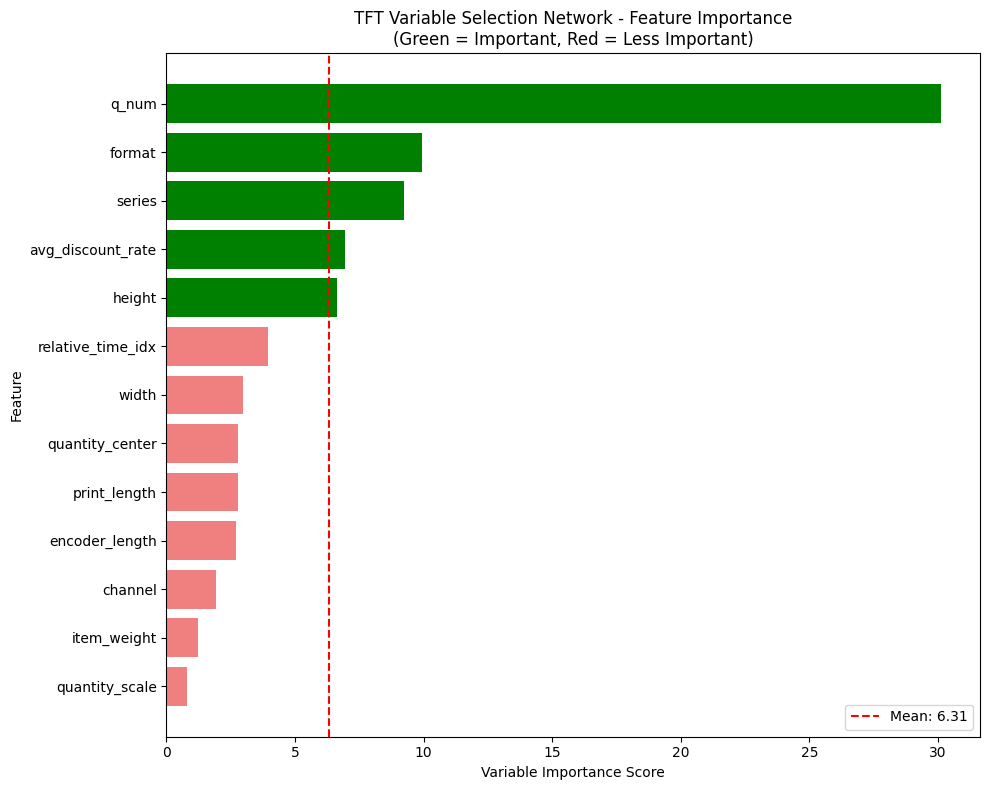


🎯 FEATURE SELECTION SUMMARY

Mean importance threshold: 6.3077

✅ TOP FEATURES (above mean importance):
  ✓ q_num: 30.1266
  ✓ format: 9.9546
  ✓ series: 9.2329
  ✓ avg_discount_rate: 6.9380
  ✓ height: 6.6289

⚠️ LOWER IMPORTANCE FEATURES (below mean):
  ✗ relative_time_idx: 3.9354
  ✗ width: 2.9784
  ✗ quantity_center: 2.7823
  ✗ print_length: 2.7658
  ✗ encoder_length: 2.6975
  ✗ channel: 1.9409
  ✗ item_weight: 1.2323
  ✗ quantity_scale: 0.7864

📌 Total features analyzed: 13
📌 High importance features: 5

✅ Feature importance saved to 'outputs/tft_feature_importance.csv'


In [12]:
# ============================================================
# Step 9: Visualize Feature Importance
# 可视化特征重要性
# ============================================================
import matplotlib.pyplot as plt

# Combine all importance scores for visualization
all_importance = {}
all_importance.update(encoder_importance)
all_importance.update(static_importance)

# Create DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': list(all_importance.keys()),
    'Importance': list(all_importance.values())
}).sort_values('Importance', ascending=True)

# Calculate mean importance as threshold
mean_importance = importance_df['Importance'].mean()

# Plot horizontal bar chart
plt.figure(figsize=(10, 8))
colors = ['green' if imp >= mean_importance else 'lightcoral'
          for imp in importance_df['Importance']]
plt.barh(importance_df['Feature'], importance_df['Importance'], color=colors)
plt.axvline(x=mean_importance, color='red', linestyle='--',
            label=f'Mean: {mean_importance:.2f}')
plt.xlabel('Variable Importance Score')
plt.ylabel('Feature')
plt.title('TFT Variable Selection Network - Feature Importance\n(Green = Important, Red = Less Important)')
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# Feature Selection Summary
# 特征选择汇总
# ============================================================
print("\n" + "="*60)
print("🎯 FEATURE SELECTION SUMMARY")
print("="*60)

print(f"\nMean importance threshold: {mean_importance:.4f}")

# Sort by importance
sorted_features = sorted(all_importance.items(), key=lambda x: -x[1])

print("\n✅ TOP FEATURES (above mean importance):")
selected_features = []
for var, importance in sorted_features:
    if importance >= mean_importance:
        print(f"  ✓ {var}: {importance:.4f}")
        selected_features.append(var)

print("\n⚠️ LOWER IMPORTANCE FEATURES (below mean):")
for var, importance in sorted_features:
    if importance < mean_importance:
        print(f"  ✗ {var}: {importance:.4f}")

print(f"\n📌 Total features analyzed: {len(all_importance)}")
print(f"📌 High importance features: {len(selected_features)}")

# Save feature importance to CSV
importance_df_sorted = importance_df.sort_values('Importance', ascending=False)
importance_df_sorted['Selected'] = importance_df_sorted['Importance'] >= mean_importance
output_folder = Path("outputs")
output_folder.mkdir(parents=True, exist_ok=True)
importance_df_sorted.to_csv(output_folder / 'tft_feature_importance.csv', index=False)
print("\n✅ Feature importance saved to 'outputs/tft_feature_importance.csv'")


🔮 Preparing 2026 predictions for TARGET BOOKS...
📊 Training data summary (AGGREGATED by ISBN+Quarter):
   Total rows: 423
   Unique ISBNs: 119
   Quantity stats: mean=149.2, median=46.0, max=1873.0

Target books loaded: 32 rows
Unique target books: 7
  1. Dog Man #13: Big Jim Begins (HB)... (dog_man)
  2. Cat Kid Comic Club #5: Influencers (HB)... (cat_kid)
  3. Captain Underpants #12: Captain Underpants... (captain_underpants)
  4. Captain Underpants and the Sen... (captain_underpants)
  5. Andy Griffiths: The 169 Storey Treehouse (PB)... (andy_griffiths)
  6. Guinness World Records 2025... (guinness)
  7. Guinness World Records Gamer's Edition 2025... (guinness)

📊 CALCULATING PREDICTIONS FROM AGGREGATED DATA

1️⃣ Series quarterly statistics (from aggregated data):

Series statistics (AGGREGATED quantities):
  andy_griffiths: total=12999, mean/record=200.0, books=18, per-book-quarterly≈200.0
  captain_underpants: total=7702, mean/record=36.9, books=56, per-book-quarterly≈36.9
  cat_k

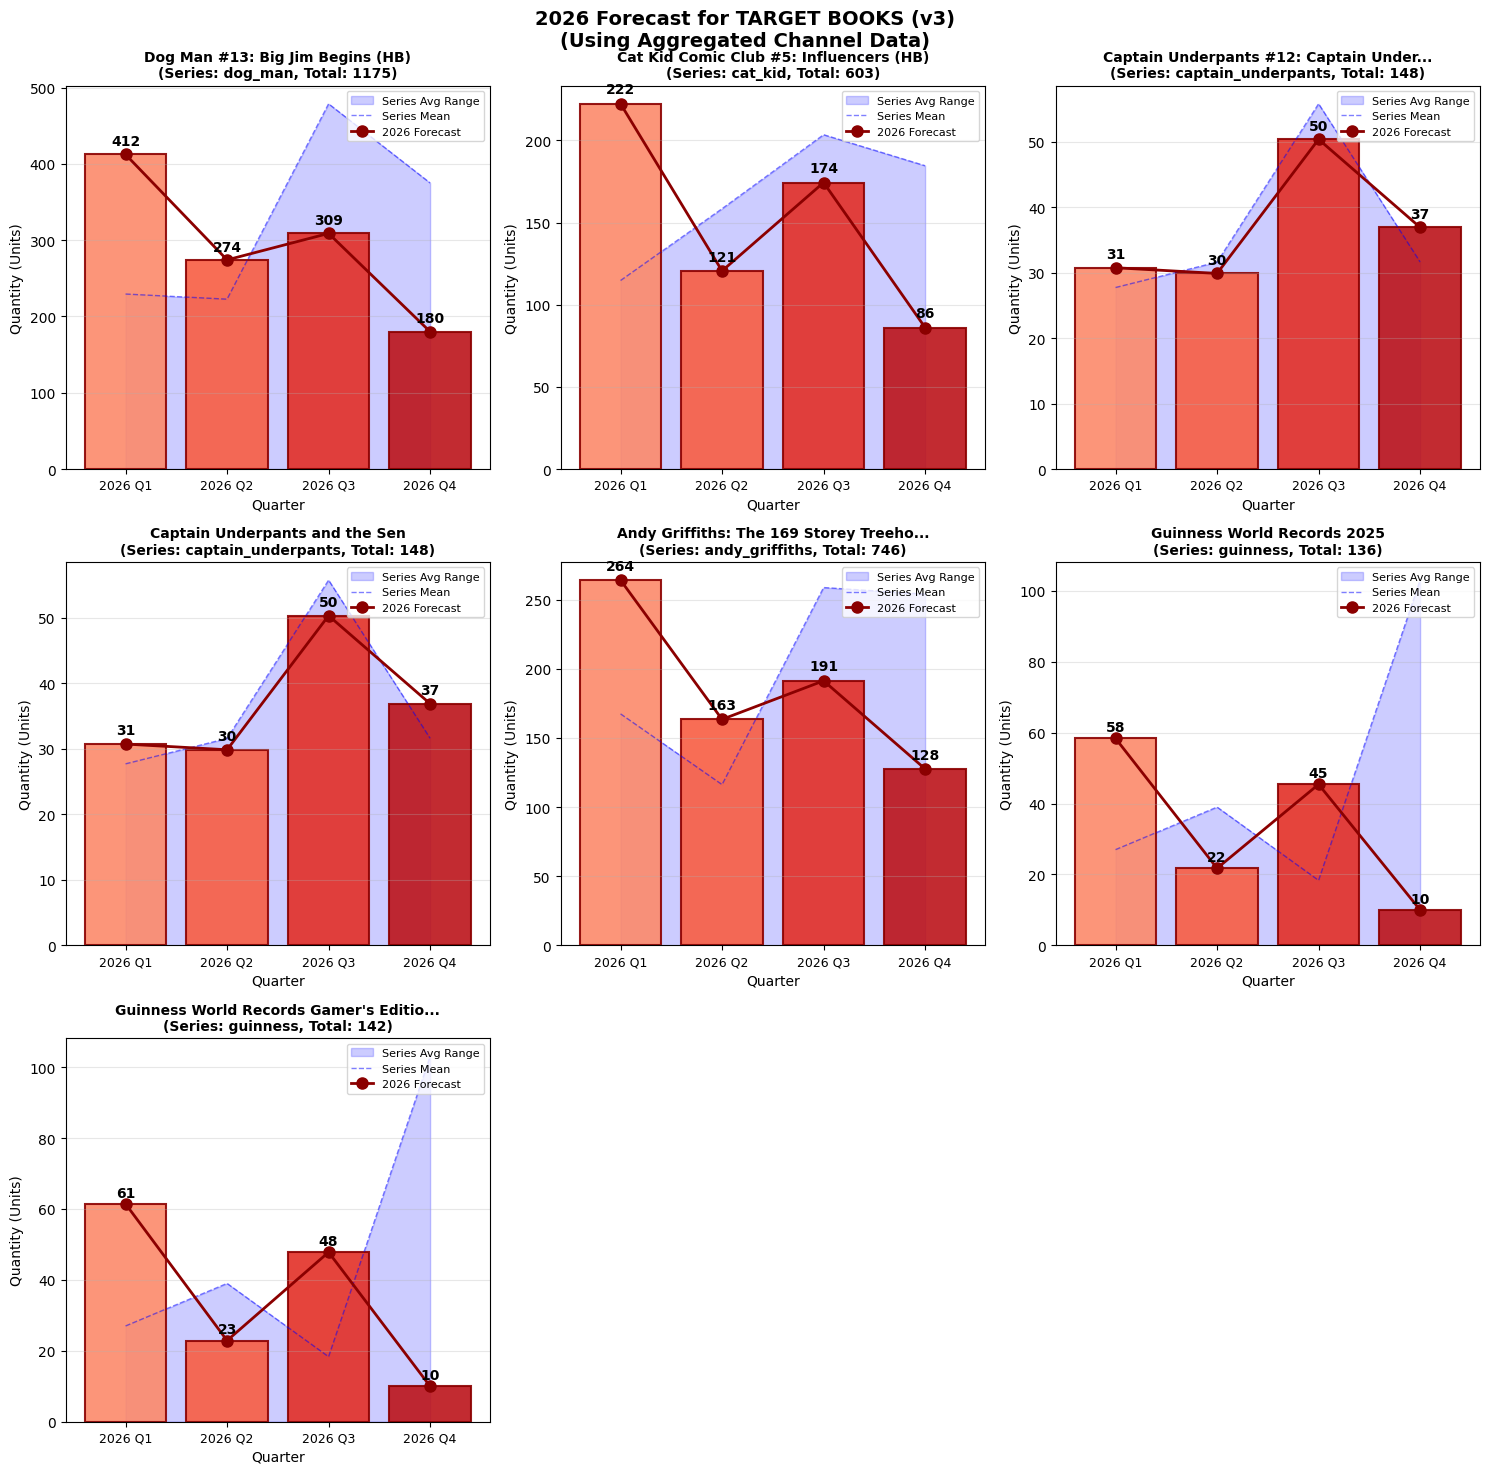


📊 TARGET BOOKS 2026 PREDICTION SUMMARY (Aggregated Scale)
Book Title                                    Series          Q1       Q2       Q3       Q4       Total     
----------------------------------------------------------------------------------------------------
Dog Man #13: Big Jim Begins (HB)              dog_man             412     274     309     180       1175
Cat Kid Comic Club #5: Influencers (HB)       cat_kid             222     121     174      86        603
Captain Underpants #12: Captain Underpants    captain_under        31      30      50      37        148
Captain Underpants and the Sen                captain_under        31      30      50      37        148
Andy Griffiths: The 169 Storey Treehouse...   andy_griffith       264     163     191     128        746
Guinness World Records 2025                   guinness             58      22      45      10        136
Guinness World Records Gamer's Edition 2025   guinness             61      23      48      10        

In [13]:
# ============================================================
# Step 10: Make 2026 Predictions for TARGET BOOKS (IMPROVED v3)
# 为目标书籍进行2026年预测（改进版v3 - 使用汇总数据）
# ============================================================

print("🔮 Preparing 2026 predictions for TARGET BOOKS...")
print("="*70)

# Verify we're using AGGREGATED data (summed across channels)
print(f"📊 Training data summary (AGGREGATED by ISBN+Quarter):")
print(f"   Total rows: {len(df_imputed)}")
print(f"   Unique ISBNs: {df_imputed['isbn'].nunique()}")
print(
    f"   Quantity stats: mean={df_imputed['quantity'].mean():.1f}, median={df_imputed['quantity'].median():.1f}, max={df_imputed['quantity'].max():.1f}")

# Load target books with titles
target_books_pred = pd.read_csv(
    data_folder / 'target_books_new.csv',
    dtype={"isbn": "string", "q_num": "string"}
)
print(f"\nTarget books loaded: {len(target_books_pred)} rows")

# Get unique target books by ISBN
unique_target_books = target_books_pred.drop_duplicates(subset=['isbn'])[
    ['isbn', 'title', 'series', 'format', 'price', 'print_length']
].reset_index(drop=True)
print(f"Unique target books: {len(unique_target_books)}")

for i, row in unique_target_books.iterrows():
    print(f"  {i+1}. {row['title'][:50]}... ({row['series']})")

# ============================================================
# Calculate series statistics from AGGREGATED data
# 从汇总数据计算系列统计
# ============================================================

print("\n" + "="*70)
print("📊 CALCULATING PREDICTIONS FROM AGGREGATED DATA")
print("="*70)

# Step 1: Series quarterly totals (sum of all books in series per quarter)
print("\n1️⃣ Series quarterly statistics (from aggregated data):")

# Get series statistics - using SUM for total and MEAN for per-book average
series_stats = df_imputed.groupby('series').agg({
    'quantity': ['sum', 'mean', 'median', 'std', 'count'],
    'isbn': 'nunique'
}).reset_index()
series_stats.columns = ['series', 'total_qty', 'mean_qty',
                        'median_qty', 'std_qty', 'n_records', 'n_books']

# Per-book quarterly average
series_stats['per_book_quarterly_avg'] = series_stats['total_qty'] / \
    series_stats['n_books'] / \
    (series_stats['n_records'] / series_stats['n_books'])

print("\nSeries statistics (AGGREGATED quantities):")
for _, row in series_stats.iterrows():
    print(f"  {row['series']}: total={row['total_qty']:.0f}, mean/record={row['mean_qty']:.1f}, books={row['n_books']}, per-book-quarterly≈{row['per_book_quarterly_avg']:.1f}")

# Quarterly pattern by series
series_quarterly = df_imputed.groupby(['series', 'q_num']).agg({
    'quantity': ['sum', 'mean', 'median', 'count']
}).reset_index()
series_quarterly.columns = ['series', 'q_num',
                            'q_total', 'q_mean', 'q_median', 'q_count']

# Step 2: Get first-year patterns (now with proper aggregated values)
print("\n2️⃣ First-year sales patterns by series (aggregated):")


def get_first_year_pattern_aggregated(series_name, historical_df):
    """Get typical first-year quarterly sales for a NEW book in this series"""
    series_data = historical_df[historical_df['series'] == series_name]

    if len(series_data) == 0:
        return None

    # Get first 4 quarters for each book
    first_year_data = []
    for isbn in series_data['isbn'].unique():
        book_data = series_data[series_data['isbn'] ==
                                isbn].sort_values('q_since_first').head(4)
        for idx, (_, row) in enumerate(book_data.iterrows()):
            first_year_data.append({
                'isbn': isbn,
                'q_idx': idx + 1,
                'quantity': row['quantity']  # This is now AGGREGATED quantity
            })

    if len(first_year_data) == 0:
        return None

    first_year_df = pd.DataFrame(first_year_data)
    # Use MEAN to get typical first-year pattern (aggregated values are larger)
    pattern = first_year_df.groupby('q_idx')['quantity'].mean().to_dict()
    return pattern


first_year_patterns = {}
for series in df_imputed['series'].unique():
    pattern = get_first_year_pattern_aggregated(series, df_imputed)
    if pattern:
        first_year_patterns[series] = pattern
        q_str = ", ".join(
            [f"Q{k}:{v:.0f}" for k, v in sorted(pattern.items())])
        print(f"  {series}: {q_str}")

# Step 3: Seasonality from aggregated data
print("\n3️⃣ Quarterly seasonality factors:")
overall_q_sum = df_imputed.groupby('q_num')['quantity'].mean()
overall_mean = df_imputed['quantity'].mean()
seasonality_factors = (overall_q_sum / overall_mean).to_dict()

for q, factor in sorted(seasonality_factors.items()):
    print(f"    Q{q}: {factor:.2f}x (avg={overall_q_sum[q]:.0f})")

# ============================================================
# Generate Predictions with PROPER SCALE
# ============================================================
print("\n4️⃣ Generating predictions (using aggregated scale)...")

book_predictions = {}

for idx, row in unique_target_books.iterrows():
    isbn = row['isbn']
    title = row['title']
    series = row['series']
    target_format = row['format']

    # Get 2026 quarter data for this book
    book_2026 = target_books_pred[target_books_pred['isbn'] == isbn].drop_duplicates(
        subset=['q_num']).sort_values('q_num')

    quarterly_preds = []

    # Get series first-year pattern
    if series in first_year_patterns:
        first_year = first_year_patterns[series]
        method_used = "First-Year Pattern (Aggregated)"
    else:
        first_year = None
        method_used = "Series Average (Aggregated)"

    # Get series baseline from aggregated stats
    series_row = series_stats[series_stats['series'] == series]
    if len(series_row) > 0:
        # Mean of aggregated quantities
        series_baseline = series_row['mean_qty'].values[0]
    else:
        series_baseline = df_imputed['quantity'].mean()

    # Generate prediction for each quarter
    for q_idx, (_, q_row) in enumerate(book_2026.iterrows(), 1):
        q_num = q_row['q_num']

        # Use first-year pattern (now with aggregated values)
        if first_year and q_idx in first_year:
            base_pred = first_year[q_idx]
        else:
            # Fallback: series quarterly mean (aggregated)
            q_avg = series_quarterly[
                (series_quarterly['series'] == series) &
                (series_quarterly['q_num'] == q_num)
            ]['q_mean']
            if len(q_avg) > 0:
                base_pred = q_avg.values[0]
            else:
                base_pred = series_baseline

        # Apply mild seasonality adjustment
        season_factor = seasonality_factors.get(q_num, 1.0)
        # Dampen seasonality effect to avoid extreme swings
        dampened_season = 1 + (season_factor - 1) * 0.5
        adjusted_pred = base_pred * dampened_season

        # Format adjustment
        format_factor = 1.0
        if target_format == 'hardcover':
            format_factor = 0.95

        final_pred = max(10, adjusted_pred * format_factor)  # Minimum 10
        quarterly_preds.append(final_pred)

    book_predictions[isbn] = {
        'title': title,
        'series': series,
        'format': target_format,
        'pred_type': method_used,
        'quarterly_preds': quarterly_preds,
        'quarters': book_2026['q_num'].tolist(),
        'series_baseline': series_baseline
    }

print("\n✅ Predictions generated with proper scale!")

# ============================================================
# Visualize Predictions
# ============================================================

n_books = len(unique_target_books)
n_cols = 3
n_rows = (n_books + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_books > 1 else [axes]

for idx, (_, book_row) in enumerate(unique_target_books.iterrows()):
    isbn = book_row['isbn']
    book_title = book_row['title']

    ax = axes[idx]
    pred_data = book_predictions[isbn]
    quarterly_preds = pred_data['quarterly_preds']
    quarters = pred_data['quarters']
    n_quarters = len(quarterly_preds)
    series = pred_data['series']

    # Plot series historical mean by quarter
    series_hist = series_quarterly[series_quarterly['series'] == series].sort_values(
        'q_num')
    if len(series_hist) > 0:
        x_hist = range(len(series_hist))
        ax.fill_between(x_hist, 0, series_hist['q_mean'].values,
                        alpha=0.2, color='blue', label='Series Avg Range')
        ax.plot(x_hist, series_hist['q_mean'].values, 'b--',
                linewidth=1, alpha=0.5, label='Series Mean')

    # Plot 2026 forecast
    x_pos = range(n_quarters)
    colors = plt.cm.Reds(np.linspace(0.4, 0.8, n_quarters))
    bars = ax.bar(x_pos, quarterly_preds, color=colors,
                  edgecolor='darkred', linewidth=1.5, alpha=0.9)
    ax.plot(x_pos, quarterly_preds, 'r-o', linewidth=2, markersize=8,
            label='2026 Forecast', color='darkred')

    # Add value labels
    for bar, val in zip(bars, quarterly_preds):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(quarterly_preds)*0.02,
                f'{val:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Set x-axis labels
    quarter_labels = [f'2026 Q{q}' for q in quarters]
    ax.set_xticks(list(range(n_quarters)))
    ax.set_xticklabels(quarter_labels, fontsize=9)

    ax.set_ylabel('Quantity (Units)')
    ax.set_xlabel('Quarter')

    # Title
    display_title = book_title if len(
        book_title) <= 40 else book_title[:37] + '...'
    total_2026 = sum(quarterly_preds)
    ax.set_title(f"{display_title}\n(Series: {series}, Total: {total_2026:.0f})",
                 fontsize=10, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(bottom=0)

# Hide unused subplots
for idx in range(n_books, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('2026 Forecast for TARGET BOOKS (v3)\n(Using Aggregated Channel Data)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================
# Print Summary
# ============================================================
print("\n" + "="*80)
print("📊 TARGET BOOKS 2026 PREDICTION SUMMARY (Aggregated Scale)")
print("="*80)
print(f"{'Book Title':<45} {'Series':<15} {'Q1':<8} {'Q2':<8} {'Q3':<8} {'Q4':<8} {'Total':<10}")
print("-"*100)

for isbn, pred_data in book_predictions.items():
    title = pred_data['title']
    display_title = title if len(title) <= 43 else title[:40] + '...'
    series = pred_data['series'][:13]
    preds = pred_data['quarterly_preds']
    total_2026 = sum(preds)

    # Pad predictions if less than 4 quarters
    while len(preds) < 4:
        preds.append(0)

    print(
        f"{display_title:<45} {series:<15} {preds[0]:>7.0f} {preds[1]:>7.0f} {preds[2]:>7.0f} {preds[3]:>7.0f} {total_2026:>10.0f}")

print("-"*100)
total_all = sum(sum(p['quarterly_preds']) for p in book_predictions.values())
print(f"{'TOTAL (all target books)':<45} {'':<15} {'':<8} {'':<8} {'':<8} {'':<8} {total_all:>10.0f}")

# Save predictions
predictions_output = []
for isbn, pred_data in book_predictions.items():
    for q_num, pred in zip(pred_data['quarters'], pred_data['quarterly_preds']):
        predictions_output.append({
            'isbn': isbn,
            'title': pred_data['title'],
            'series': pred_data['series'],
            'format': pred_data['format'],
            'quarter': f'2026_Q{q_num}',
            'predicted_quantity': round(pred, 0),
            'prediction_method': pred_data['pred_type'],
            'series_baseline': round(pred_data['series_baseline'], 0)
        })

predictions_df = pd.DataFrame(predictions_output)
predictions_df.to_csv(
    output_folder / 'tft_target_books_2026_predictions.csv', index=False)
print(f"\n✅ Predictions saved to 'outputs/tft_target_books_2026_predictions.csv'")
